# Diffusion equation in TCLB solver #


In this workshop we will cover basic conceptions related to TCLB solver. We will not dive into detail of TCLB compilation or model development - it is out of scope of this tutorial and is covered in other materials. 


## What is included in this environment

To run TCLB model us ipython shell binding:
```python
! tclb ModelName ConfigurationFile.xml 
```

This will effectivelu run (in the curren working directory)
```
$TCLB_PATH/CLB/ModelName/main ConfigurationFile.xml
```
in your Jupyter/Binder.  We will use

```python
! tclb ModelName ConfigurationFile.xml  > /dev/null && echo "DONE!"
```
to supress output in most cases.

## TCLB solver

As you might noticed TCLB is a set of models (like d2q9). TCLB uses XML as source of configuration plus limited numebr of command line options which will be covered latter. There is a python library that helps you build XML on-the-fly if You like.



In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from display_xml import XML


# Basic configuration file #

In [2]:
f = open('./SimpleDiffusion.xml', 'r')
XML(''.join(f.readlines()))

# Let's see what is in there:

```xml

<CLBConfig version="2.0" output="output/SimpleDiffusion/"> <!-- The root xml element -->
  <Geometry nx="100" ny="100"> <!-- Mesh size, by default nz=1. MPI divisions are along X -->
    <None name="city"> <!--Named zone or BC, part of the mesh that could be referenced in Model section  -->
      <Box dx="35" nx="30"/> <!-- Markers/geometrical descriptions of the parent zone -->
    </None>
  </Geometry>
  <Model> <!-- Here we set the model parameters, like viscosity -->
    <Param name="Diffusivity_DRE_1" value="0.1666"/> <!-- or Diffusivity for Diffusive-Reactive-Equation #1  -->
    <Param name="Init_DRE_1" value="-0.5"/> <!-- Initial value for Diffusive-Reactive-Equation #1  -->
    <Param name="Init_DRE_1" value="0.5" zone="city"/> <!-- Initial value for Diffusive-Reactive-Equation #1  in Zone City -->
  </Model>
  <HDF5/> <!-- Save at t=0  -->
  <Solve Iterations="200"> <!-- Iterate 100 iterations -->
    <HDF5 Iterations="10"/> <!-- Save HDF5 every 10, HDF5 could be replaced by VTK -->
  </Solve>
</CLBConfig>

```

## and let's run it:

In [12]:
! tclb d2q9_reaction_diffusion_system_SimpleDiffusion SimpleDiffusion.xml 

MPMD: TCLB: local:0/1 work:0/1 ---  connected to:
[  ] -------------------------------------------------------------------------
[  ] -  CLB version:   v6.0-beta-1712-g99b67bb                               -
[  ] -        Model: d2q9_reaction_diffusion_system_SimpleDiffusion                  
[  ]              -
[  ] -------------------------------------------------------------------------
[  ] Setting output path to: SimpleDiffusion
[  ] Discarding 1 comments
[ 0] Running on CPU
[ 0] WARNING: No "Units" element in config file
[  ] Mesh size in config file: 100x100x1
[  ] Global lattice size: 100x100x1
[  ] Max region size: 10000. Mesh size 10000. Overhead:  0%
[  ] Local lattice size: 100x100x1
Hello allocator!
[  ]   Threads  |      Action
[  ]     1x1    | Primal , NoGlobals , BaseIteration
[  ]     1x1    | Tangent , NoGlobals , BaseIteration
[  ]     1x1    | Optimize , NoGlobals , BaseIteration
[  ]     1x1    | SteadyAdjoint , NoGlobals , BaseIteration
[  ]     1x1    | Primal ,

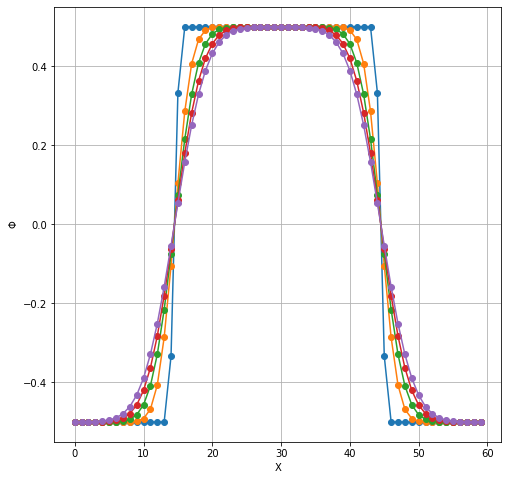

In [13]:
TimeSteps = list()

for i in range(0,200,10):
    f = h5py.File('./output/SimpleDiffusion/SimpleDiffusion_HDF5_%08d.h5'%i)    
    TimeSteps.append(f['DRE_1'][0,:,:])
    
TimeSteps = np.array(TimeSteps)

plt.figure(figsize=(8,8))
plt.plot(TimeSteps[:5,25,20:80].T, 'o-');
plt.grid(which='both');
plt.xlabel('X');
plt.ylabel(r'$\Phi$');


We could also extract 1D image

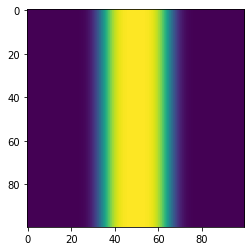

In [5]:
plt.imshow(TimeSteps[5])

# Using TCLBConfig writer class 

Now, we are gona generate same XML file using XML library. A nice think is that we could use it to do some parametric studies. It also does limited "syntax" check.

In [17]:
import CLB.CLBXMLWriter as CLBXML   

In [18]:
CLBc = CLBXML.CLBConfigWriter( )

CLBc.addGeomParam('nx', 100)
CLBc.addGeomParam('ny', 100)

CLBc.addNone(name="city")
CLBc.addBox(dx=35, nx=35)

params = {
        "Diffusivity_DRE_1":0.1666,
        "Init_DRE_1":-0.5
}

CLBc.addModelParams(params)

params = {
        "Init_DRE_1":-0.5
}

CLBc.addHDF5()
CLBc.addModelParams(params, zone='city')
solve = CLBc.addSolve(iterations=200)
CLBc.addHDF5(Iterations=10, parent=solve)
   
CLBc.write('run.xml')


Apart from float representation, the resulting file is identical

In [20]:
f = open('run.xml', 'r')
XML(''.join(f.readlines()))

In [25]:
! tclb d2q9_reaction_diffusion_system_SimpleDiffusion run.xml > /dev/null && echo "DONE!"

Hello allocator!
DONE!


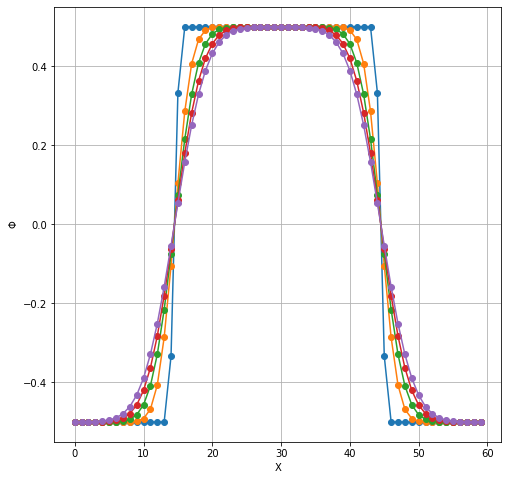

In [26]:
TimeSteps2 = list()

for i in range(0,200,10):
    f = h5py.File('./output/run_HDF5_%08d.h5'%i)    
    TimeSteps2.append(f['DRE_1'][0,:,:])
    
TimeSteps2 = np.array(TimeSteps)

plt.figure(figsize=(8,8))
plt.plot(TimeSteps2[:5,25,20:80].T, 'o-');
plt.grid(which='both');
plt.xlabel('X');
plt.ylabel(r'$\Phi$');